# Conditional Latent Class Model for Multivariate Categorical Data

Implementation of the conditional latent class model using EM algorithm with Newton-Raphson optimization.

**Model:**
$$P(X = x|Z) = \sum_{k=1}^{K} P(H = k|Z) \prod_{r=1}^{m} P(X^{(r)} = x^{(r)} | H = k)$$

where $\pi_k(Z) = P(H=k|Z)$ follows a multinomial logistic regression:
$$\pi_k(z) = \frac{\exp(\alpha_k + \beta_k^\top z)}{\sum_{j=1}^{K} \exp(\alpha_j + \beta_j^\top z)}$$

with identifiability constraint $\alpha_K = 0, \beta_K = 0$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. Synthetic Data Generation

In [2]:
def generate_synthetic_data(n_samples, n_variables, categories_per_variable, 
                           n_classes, covariate_dim, random_seed=42):
    """
    Generate synthetic data from conditional latent class model.
    
    Parameters:
    -----------
    n_samples : int
        Number of samples to generate
    n_variables : int
        Number of categorical variables (m)
    categories_per_variable : list of int
        Number of categories for each variable [C1, C2, ..., Cm]
    n_classes : int
        Number of latent classes (K)
    covariate_dim : int
        Dimension of covariate Z
    random_seed : int
        Random seed for reproducibility
        
    Returns:
    --------
    Z : ndarray of shape (n_samples, covariate_dim)
        Covariates
    X : ndarray of shape (n_samples, n_variables)
        Categorical observations (0-indexed)
    true_params : dict
        Dictionary containing true parameters (alpha, beta, theta)
    """
    np.random.seed(random_seed)
    
    # Generate true parameters
    # Alpha: intercepts for K-1 classes (last class has alpha_K = 0)
    true_alpha = np.random.randn(n_classes - 1) * 0.5
    
    # Beta: coefficients for K-1 classes (last class has beta_K = 0)
    true_beta = np.random.randn(n_classes - 1, covariate_dim) * 0.5
    
    # Theta: class-conditional categorical probabilities
    # theta[k, r, :] = probabilities for class k, variable r
    true_theta = np.zeros((n_classes, n_variables, max(categories_per_variable)))
    for k in range(n_classes):
        for r in range(n_variables):
            # Generate random probabilities and normalize
            probs = np.random.dirichlet(np.ones(categories_per_variable[r]))
            true_theta[k, r, :categories_per_variable[r]] = probs
    
    # Generate covariates Z from standard normal
    Z = np.random.randn(n_samples, covariate_dim)
    
    # Compute class probabilities pi_k(Z) for each sample
    # Shape: (n_samples, n_classes)
    logits = np.zeros((n_samples, n_classes))
    logits[:, :-1] = true_alpha + Z @ true_beta.T  # K-1 classes
    # Last class has logit 0 (alpha_K = 0, beta_K = 0)
    
    # Compute probabilities using softmax
    exp_logits = np.exp(logits - logits.max(axis=1, keepdims=True))
    pi_z = exp_logits / exp_logits.sum(axis=1, keepdims=True)
    
    # Sample latent classes H
    H = np.array([np.random.choice(n_classes, p=pi_z[i]) for i in range(n_samples)])
    
    # Sample categorical variables X given H
    X = np.zeros((n_samples, n_variables), dtype=int)
    for i in range(n_samples):
        h = H[i]
        for r in range(n_variables):
            probs = true_theta[h, r, :categories_per_variable[r]]
            X[i, r] = np.random.choice(categories_per_variable[r], p=probs)
    
    true_params = {
        'alpha': true_alpha,
        'beta': true_beta,
        'theta': true_theta,
        'H': H  # True latent classes for reference
    }
    
    return Z, X, true_params

## 2. Conditional Latent Class Model Implementation

In [3]:
class ConditionalLatentClassModel:
    """
    Conditional Latent Class Model for multivariate categorical data.
    
    Uses EM algorithm with Newton-Raphson optimization for the M-step.
    """
    
    def __init__(self, n_classes, categories_per_variable, covariate_dim,
                 max_iter_em=100, tol_em=1e-6,
                 max_iter_newton=20, tol_newton=1e-6,
                 random_seed=42):
        """
        Initialize the conditional latent class model.
        
        Parameters:
        -----------
        n_classes : int
            Number of latent classes (K)
        categories_per_variable : list of int
            Number of categories for each variable
        covariate_dim : int
            Dimension of covariates
        max_iter_em : int
            Maximum EM iterations
        tol_em : float
            Convergence tolerance for EM (log-likelihood change)
        max_iter_newton : int
            Maximum Newton-Raphson iterations
        tol_newton : float
            Convergence tolerance for Newton-Raphson (gradient norm)
        random_seed : int
            Random seed for initialization
        """
        self.K = n_classes
        self.categories_per_variable = categories_per_variable
        self.m = len(categories_per_variable)
        self.d = covariate_dim
        self.max_iter_em = max_iter_em
        self.tol_em = tol_em
        self.max_iter_newton = max_iter_newton
        self.tol_newton = tol_newton
        self.random_seed = random_seed
        
        # Initialize parameters
        np.random.seed(random_seed)
        self._initialize_parameters()
        
        # Storage for tracking convergence
        self.log_likelihoods = []
        self.converged = False
        
    def _initialize_parameters(self):
        """
        Random initialization of model parameters.
        """
        # Alpha: (K-1,) - intercepts for first K-1 classes
        self.alpha = np.random.randn(self.K - 1) * 0.1
        
        # Beta: (K-1, d) - coefficients for first K-1 classes
        self.beta = np.random.randn(self.K - 1, self.d) * 0.1
        
        # Theta: (K, m, max_categories) - class-conditional probabilities
        max_categories = max(self.categories_per_variable)
        self.theta = np.zeros((self.K, self.m, max_categories))
        for k in range(self.K):
            for r in range(self.m):
                # Random initialization with Dirichlet
                probs = np.random.dirichlet(np.ones(self.categories_per_variable[r]))
                self.theta[k, r, :self.categories_per_variable[r]] = probs
    
    def _compute_pi(self, Z):
        """
        Compute class probabilities pi_k(Z) for all samples.
        
        Parameters:
        -----------
        Z : ndarray of shape (n, d)
            Covariates
            
        Returns:
        --------
        pi : ndarray of shape (n, K)
            Class probabilities for each sample
        """
        n = Z.shape[0]
        logits = np.zeros((n, self.K))
        
        # First K-1 classes
        logits[:, :-1] = self.alpha + Z @ self.beta.T
        # Last class has logit 0 (identifiability constraint)
        
        # Softmax with numerical stability
        logits_shifted = logits - logits.max(axis=1, keepdims=True)
        exp_logits = np.exp(logits_shifted)
        pi = exp_logits / exp_logits.sum(axis=1, keepdims=True)
        
        return pi
    
    def _e_step(self, X, Z):
        """
        E-step: Compute posterior probabilities gamma_ik.
        
        Uses log-space computation with max-normalization for numerical stability.
        
        Parameters:
        -----------
        X : ndarray of shape (n, m)
            Categorical observations
        Z : ndarray of shape (n, d)
            Covariates
            
        Returns:
        --------
        gamma : ndarray of shape (n, K)
            Posterior probabilities
        """
        n = X.shape[0]
        
        # Compute pi_k(Z) for all samples
        pi = self._compute_pi(Z)  # (n, K)
        
        # Compute a_ik = log pi_k(Z_i) + sum_r log(theta_rkc) in log-space
        # Shape: (n, K)
        log_pi = np.log(pi + 1e-10)  # Add small constant for numerical stability
        
        # Compute log probabilities for observations
        # For each sample i and class k, sum log(theta[k, r, X[i,r]]) over r
        log_theta_X = np.zeros((n, self.K))
        for r in range(self.m):
            # Extract log probabilities for observed categories
            # theta[k, r, X[:, r]] for all k
            for k in range(self.K):
                log_theta_X[:, k] += np.log(self.theta[k, r, X[:, r]] + 1e-10)
        
        # a_ik = log pi_k(Z_i) + log_theta_X
        a = log_pi + log_theta_X  # (n, K)
        
        # Compute gamma using max-normalization
        # gamma_ik = exp(a_ik - M_i) / sum_j exp(a_ij - M_i)
        M = a.max(axis=1, keepdims=True)  # (n, 1)
        a_shifted = a - M
        exp_a = np.exp(a_shifted)
        gamma = exp_a / exp_a.sum(axis=1, keepdims=True)
        
        return gamma
    
    def _m_step_theta(self, X, gamma):
        """
        M-step: Update theta parameters (closed-form).
        
        Parameters:
        -----------
        X : ndarray of shape (n, m)
            Categorical observations
        gamma : ndarray of shape (n, K)
            Posterior probabilities
        """
        n = X.shape[0]
        
        # Update theta_{rkc} = sum_i gamma_ik * 1(X_i^r = c) / sum_i gamma_ik
        for k in range(self.K):
            gamma_k = gamma[:, k]  # (n,)
            for r in range(self.m):
                for c in range(self.categories_per_variable[r]):
                    # Indicator: X[:, r] == c
                    indicator = (X[:, r] == c).astype(float)
                    numerator = np.sum(gamma_k * indicator)
                    denominator = np.sum(gamma_k) + 1e-10
                    self.theta[k, r, c] = numerator / denominator
                
                # Normalize to ensure probabilities sum to 1
                theta_sum = self.theta[k, r, :self.categories_per_variable[r]].sum()
                self.theta[k, r, :self.categories_per_variable[r]] /= (theta_sum + 1e-10)
    
    def _m_step_alpha_beta(self, Z, gamma):
        """
        M-step: Update alpha and beta using Newton-Raphson.
        
        Optimizes Q_pi(alpha, beta) which is the log-likelihood of multinomial
        logistic regression with soft counts gamma.
        
        Parameters:
        -----------
        Z : ndarray of shape (n, d)
            Covariates
        gamma : ndarray of shape (n, K)
            Posterior probabilities (soft counts)
        """
        n = Z.shape[0]
        
        # Newton-Raphson iterations
        for iter_nr in range(self.max_iter_newton):
            # Compute current pi(Z)
            pi = self._compute_pi(Z)  # (n, K)
            
            # Compute gradient and Hessian for k = 0, ..., K-2
            # (K-1 classes, since last class is reference)
            
            # Gradient: g_k = [dQ/dalpha_k, dQ/dbeta_k]^T
            # g_k has dimension (1 + d,)
            # Total gradient has dimension ((K-1) * (1 + d),)
            
            grad = np.zeros((self.K - 1) * (1 + self.d))
            hess = np.zeros(((self.K - 1) * (1 + self.d), (self.K - 1) * (1 + self.d)))
            
            # Compute W_ikj = pi_k(Z_i) * (1(k=j) - pi_j(Z_i))
            # This is needed for Hessian computation
            
            for k in range(self.K - 1):
                # Gradient for class k
                # dQ/dalpha_k = sum_i (gamma_ik - pi_k(Z_i))
                grad_alpha_k = np.sum(gamma[:, k] - pi[:, k])
                # dQ/dbeta_k = sum_i (gamma_ik - pi_k(Z_i)) * Z_i
                grad_beta_k = np.sum((gamma[:, k] - pi[:, k])[:, np.newaxis] * Z, axis=0)
                
                # Store in gradient vector
                idx_k = k * (1 + self.d)
                grad[idx_k] = grad_alpha_k
                grad[idx_k + 1:idx_k + 1 + self.d] = grad_beta_k
                
                # Hessian blocks
                for j in range(self.K - 1):
                    # Compute W_ikj for all samples i
                    if k == j:
                        W_ikj = pi[:, k] * (1 - pi[:, j])  # (n,)
                    else:
                        W_ikj = -pi[:, k] * pi[:, j]  # (n,)
                    
                    # Hessian block (k, j)
                    # H_kj = -sum_i W_ikj * [[1, Z_i^T], [Z_i, Z_i Z_i^T]]
                    
                    idx_j = j * (1 + self.d)
                    
                    # d^2Q / dalpha_k dalpha_j = -sum_i W_ikj
                    hess[idx_k, idx_j] = -np.sum(W_ikj)
                    
                    # d^2Q / dalpha_k dbeta_j = -sum_i W_ikj * Z_i^T
                    hess[idx_k, idx_j + 1:idx_j + 1 + self.d] = -np.sum(W_ikj[:, np.newaxis] * Z, axis=0)
                    
                    # d^2Q / dbeta_k dalpha_j = -sum_i W_ikj * Z_i
                    hess[idx_k + 1:idx_k + 1 + self.d, idx_j] = -np.sum(W_ikj[:, np.newaxis] * Z, axis=0)
                    
                    # d^2Q / dbeta_k dbeta_j = -sum_i W_ikj * Z_i Z_i^T
                    hess[idx_k + 1:idx_k + 1 + self.d, idx_j + 1:idx_j + 1 + self.d] = \
                        -np.sum(W_ikj[:, np.newaxis, np.newaxis] * Z[:, :, np.newaxis] * Z[:, np.newaxis, :], axis=0)
            
            # Check convergence: ||gradient|| < tol
            grad_norm = np.linalg.norm(grad)
            if grad_norm < self.tol_newton:
                break
            
            # Newton update: theta_new = theta_old - H^{-1} g
            try:
                # Add small diagonal regularization for numerical stability
                hess_reg = hess + 1e-6 * np.eye(hess.shape[0])
                delta = np.linalg.solve(hess_reg, grad)
            except np.linalg.LinAlgError:
                # If Hessian is singular, use pseudo-inverse
                delta = np.linalg.lstsq(hess, grad, rcond=None)[0]
            
            # Update parameters
            for k in range(self.K - 1):
                idx_k = k * (1 + self.d)
                self.alpha[k] -= delta[idx_k]
                self.beta[k] -= delta[idx_k + 1:idx_k + 1 + self.d]
    
    def _compute_log_likelihood(self, X, Z):
        """
        Compute the observed data log-likelihood.
        
        Parameters:
        -----------
        X : ndarray of shape (n, m)
            Categorical observations
        Z : ndarray of shape (n, d)
            Covariates
            
        Returns:
        --------
        log_lik : float
            Log-likelihood value
        """
        n = X.shape[0]
        pi = self._compute_pi(Z)  # (n, K)
        
        # Compute sum_k pi_k(Z_i) * prod_r theta_rkc for each sample
        log_lik = 0.0
        for i in range(n):
            likelihood_i = 0.0
            for k in range(self.K):
                # Compute prod_r theta[k, r, X[i, r]]
                prod_theta = 1.0
                for r in range(self.m):
                    prod_theta *= self.theta[k, r, X[i, r]]
                likelihood_i += pi[i, k] * prod_theta
            log_lik += np.log(likelihood_i + 1e-10)
        
        return log_lik
    
    def _sort_classes_by_entropy(self):
        """
        Post-hoc sorting of classes by entropy to handle label switching.
        
        Sorts classes in ascending order of entropy (more concentrated first).
        """
        entropies = np.zeros(self.K)
        
        for k in range(self.K):
            entropy_k = 0.0
            for r in range(self.m):
                probs = self.theta[k, r, :self.categories_per_variable[r]]
                # Entropy: -sum p log p
                entropy_k += -np.sum(probs * np.log(probs + 1e-10))
            entropies[k] = entropy_k
        
        # Sort by entropy (ascending)
        sort_indices = np.argsort(entropies)
        
        # Permute parameters
        self.theta = self.theta[sort_indices]
        
        # For alpha and beta, we need to handle the constraint alpha_K = 0, beta_K = 0
        # Create full arrays including the last class
        alpha_full = np.zeros(self.K)
        alpha_full[:-1] = self.alpha
        alpha_full = alpha_full[sort_indices]
        
        beta_full = np.zeros((self.K, self.d))
        beta_full[:-1] = self.beta
        beta_full = beta_full[sort_indices]
        
        # Set new reference class (now the last one after sorting)
        # Subtract the last class's values to maintain constraint
        self.alpha = alpha_full[:-1] - alpha_full[-1]
        self.beta = beta_full[:-1] - beta_full[-1]
    
    def fit(self, X, Z, verbose=True):
        """
        Fit the conditional latent class model using EM algorithm.
        
        Parameters:
        -----------
        X : ndarray of shape (n, m)
            Categorical observations (0-indexed)
        Z : ndarray of shape (n, d)
            Covariates
        verbose : bool
            Whether to print progress
        """
        n = X.shape[0]
        
        # EM iterations
        for iter_em in range(self.max_iter_em):
            # E-step
            gamma = self._e_step(X, Z)
            
            # M-step
            self._m_step_theta(X, gamma)
            self._m_step_alpha_beta(Z, gamma)
            
            # Compute log-likelihood
            log_lik = self._compute_log_likelihood(X, Z)
            self.log_likelihoods.append(log_lik)
            
            if verbose and (iter_em % 10 == 0 or iter_em < 5):
                print(f"EM Iteration {iter_em}: Log-likelihood = {log_lik:.4f}")
            
            # Check convergence
            if iter_em > 0:
                log_lik_change = abs(self.log_likelihoods[-1] - self.log_likelihoods[-2])
                if log_lik_change < self.tol_em:
                    self.converged = True
                    if verbose:
                        print(f"\nConverged at iteration {iter_em}")
                        print(f"Final log-likelihood: {log_lik:.4f}")
                    break
        
        # Post-hoc sorting to handle label switching
        self._sort_classes_by_entropy()
        
        if not self.converged and verbose:
            print(f"\nReached maximum iterations ({self.max_iter_em}) without convergence")
    
    def predict_proba(self, X, Z):
        """
        Predict class probabilities for new samples.
        
        Parameters:
        -----------
        X : ndarray of shape (n, m)
            Categorical observations
        Z : ndarray of shape (n, d)
            Covariates
            
        Returns:
        --------
        gamma : ndarray of shape (n, K)
            Posterior class probabilities
        """
        return self._e_step(X, Z)

## 3. Generate Synthetic Data

In [4]:
# Configuration
n_samples = 5000
n_variables = 20
categories_per_variable = [2] * n_variables
n_classes = 3
covariate_dim = 2
random_seed = 42

# Generate data
Z, X, true_params = generate_synthetic_data(
    n_samples=n_samples,
    n_variables=n_variables,
    categories_per_variable=categories_per_variable,
    n_classes=n_classes,
    covariate_dim=covariate_dim,
    random_seed=random_seed
)

print(f"Generated data:")
print(f"  Z shape: {Z.shape}")
print(f"  X shape: {X.shape}")
print(f"  True number of classes: {n_classes}")
print(f"\nTrue class distribution: {np.bincount(true_params['H']) / n_samples}")

# Sort true parameters by entropy for fair comparison with learned parameters
def sort_true_params_by_entropy(true_params, categories_per_variable):
    """
    Sort true parameters by entropy (same method as model uses).
    This ensures fair comparison between true and learned parameters.
    """
    n_classes = true_params['theta'].shape[0]
    n_variables = len(categories_per_variable)
    
    # Compute entropy for each class
    entropies = np.zeros(n_classes)
    for k in range(n_classes):
        entropy_k = 0.0
        for r in range(n_variables):
            probs = true_params['theta'][k, r, :categories_per_variable[r]]
            entropy_k += -np.sum(probs * np.log(probs + 1e-10))
        entropies[k] = entropy_k
    
    # Sort by entropy (ascending)
    sort_indices = np.argsort(entropies)
    
    # Create sorted version of true parameters
    sorted_params = {
        'theta': true_params['theta'][sort_indices],
        'H': np.array([np.where(sort_indices == h)[0][0] for h in true_params['H']])  # Remap class labels
    }
    
    # Handle alpha and beta with constraint
    alpha_full = np.zeros(n_classes)
    alpha_full[:-1] = true_params['alpha']
    alpha_full = alpha_full[sort_indices]
    sorted_params['alpha'] = alpha_full[:-1] - alpha_full[-1]
    
    beta_full = np.zeros((n_classes, true_params['beta'].shape[1]))
    beta_full[:-1] = true_params['beta']
    beta_full = beta_full[sort_indices]
    sorted_params['beta'] = beta_full[:-1] - beta_full[-1]
    
    return sorted_params

# Sort true parameters for comparison
true_params_sorted = sort_true_params_by_entropy(true_params, categories_per_variable)
print("\nTrue parameters sorted by entropy for fair comparison with learned model.")

Generated data:
  Z shape: (5000, 2)
  X shape: (5000, 20)
  True number of classes: 3

True class distribution: [0.4028 0.2952 0.302 ]

True parameters sorted by entropy for fair comparison with learned model.


## 4. Fit the Model

In [5]:
# Initialize and fit model
model = ConditionalLatentClassModel(
    n_classes=n_classes,
    categories_per_variable=categories_per_variable,
    covariate_dim=covariate_dim,
    max_iter_em=200,
    tol_em=1e-6,
    max_iter_newton=200,
    tol_newton=1e-6,
    random_seed=42
)

# Fit the model
model.fit(X, Z, verbose=True)

EM Iteration 0: Log-likelihood = -53861.9368
EM Iteration 1: Log-likelihood = -53860.8787
EM Iteration 2: Log-likelihood = -53860.8171
EM Iteration 3: Log-likelihood = -53860.8101
EM Iteration 4: Log-likelihood = -53860.8091
EM Iteration 10: Log-likelihood = -53860.8088

Converged at iteration 10
Final log-likelihood: -53860.8088


## 5. Visualizations

### 5.1 Log-likelihood Convergence

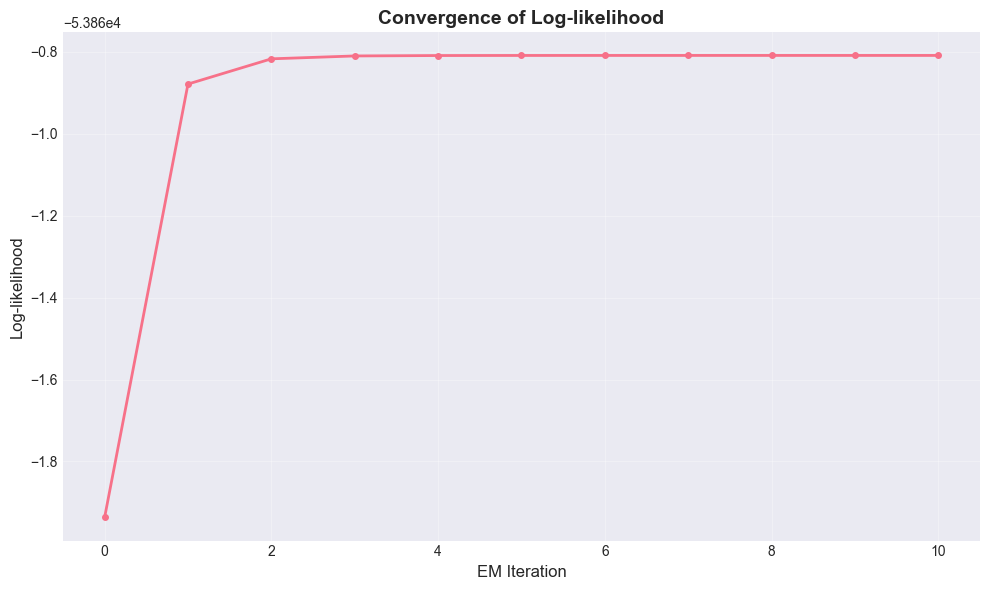

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(model.log_likelihoods, linewidth=2, marker='o', markersize=4)
plt.xlabel('EM Iteration', fontsize=12)
plt.ylabel('Log-likelihood', fontsize=12)
plt.title('Convergence of Log-likelihood', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.2 True vs Learned Theta Distributions

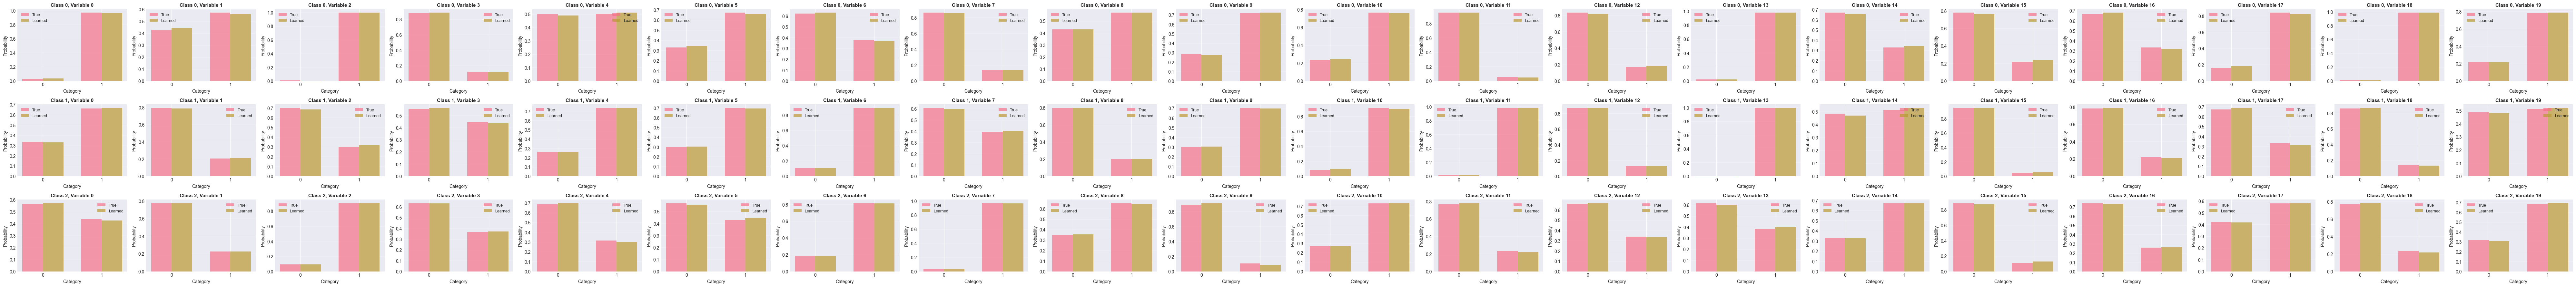

In [7]:
# Compare true vs learned theta for each class and variable
fig, axes = plt.subplots(n_classes, n_variables, figsize=(4 * n_variables, 3 * n_classes))

if n_classes == 1:
    axes = axes.reshape(1, -1)
if n_variables == 1:
    axes = axes.reshape(-1, 1)

for k in range(n_classes):
    for r in range(n_variables):
        ax = axes[k, r]
        n_categories = categories_per_variable[r]
        
        # True and learned probabilities (using sorted true params)
        true_probs = true_params_sorted['theta'][k, r, :n_categories]
        learned_probs = model.theta[k, r, :n_categories]
        
        x = np.arange(n_categories)
        width = 0.35
        
        ax.bar(x - width/2, true_probs, width, label='True', alpha=0.7)
        ax.bar(x + width/2, learned_probs, width, label='Learned', alpha=0.7)
        
        ax.set_xlabel('Category', fontsize=10)
        ax.set_ylabel('Probability', fontsize=10)
        ax.set_title(f'Class {k}, Variable {r}', fontsize=11, fontweight='bold')
        ax.legend(fontsize=9)
        ax.set_xticks(x)
        ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 5.3 Heatmap Comparison of Theta

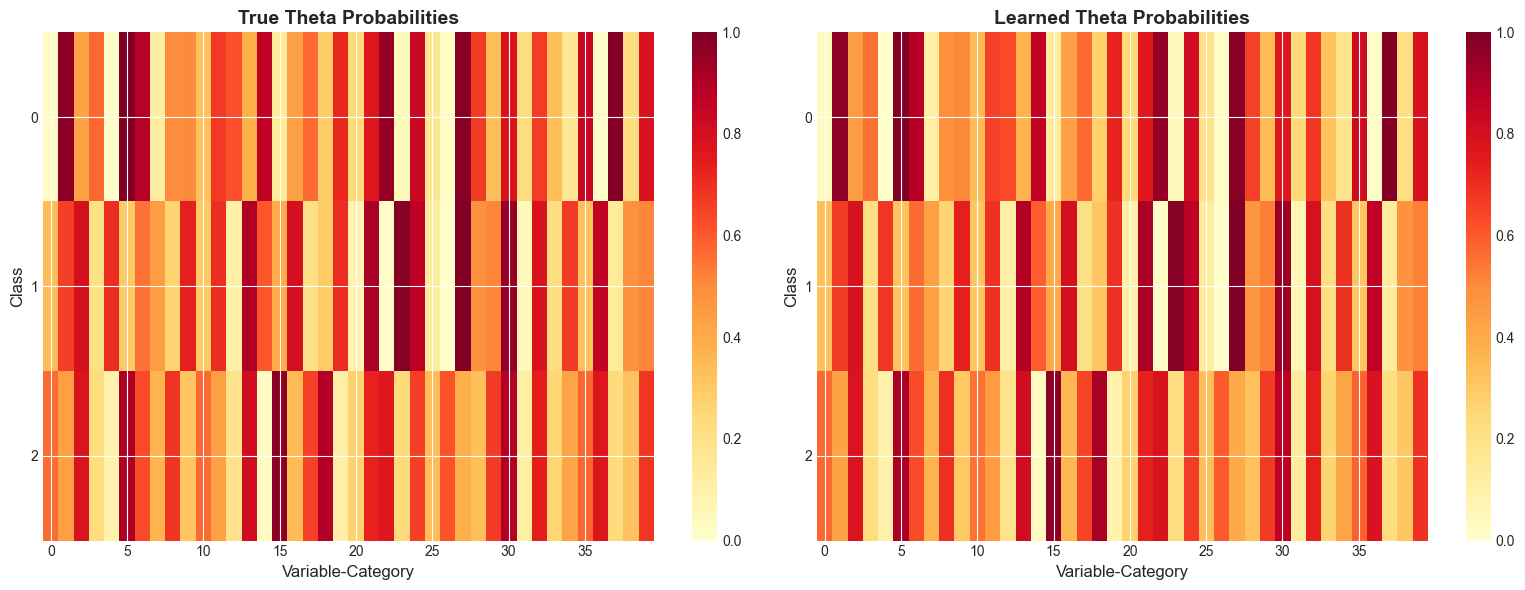

In [8]:
# Create heatmaps for true vs learned theta
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Prepare data for heatmap (flatten across variables and categories)
max_categories = max(categories_per_variable)

# True theta
true_theta_flat = np.zeros((n_classes, n_variables * max_categories))
learned_theta_flat = np.zeros((n_classes, n_variables * max_categories))

for r in range(n_variables):
    start_idx = r * max_categories
    end_idx = start_idx + categories_per_variable[r]
    true_theta_flat[:, start_idx:end_idx] = true_params_sorted['theta'][:, r, :categories_per_variable[r]]
    learned_theta_flat[:, start_idx:end_idx] = model.theta[:, r, :categories_per_variable[r]]

# Plot true theta
im1 = axes[0].imshow(true_theta_flat, aspect='auto', cmap='YlOrRd', vmin=0, vmax=1)
axes[0].set_xlabel('Variable-Category', fontsize=12)
axes[0].set_ylabel('Class', fontsize=12)
axes[0].set_title('True Theta Probabilities', fontsize=14, fontweight='bold')
axes[0].set_yticks(range(n_classes))
plt.colorbar(im1, ax=axes[0])

# Plot learned theta
im2 = axes[1].imshow(learned_theta_flat, aspect='auto', cmap='YlOrRd', vmin=0, vmax=1)
axes[1].set_xlabel('Variable-Category', fontsize=12)
axes[1].set_ylabel('Class', fontsize=12)
axes[1].set_title('Learned Theta Probabilities', fontsize=14, fontweight='bold')
axes[1].set_yticks(range(n_classes))
plt.colorbar(im2, ax=axes[1])

plt.tight_layout()
plt.show()

### 5.4 Class Assignment Probabilities

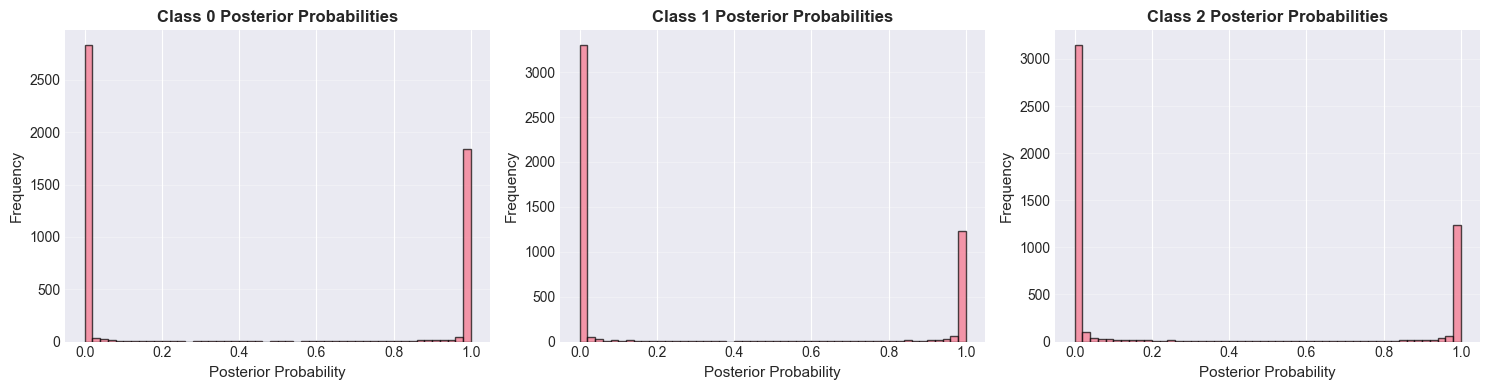

In [9]:
# Get posterior probabilities for all samples
gamma = model.predict_proba(X, Z)

# Plot distribution of posterior probabilities
fig, axes = plt.subplots(1, n_classes, figsize=(5 * n_classes, 4))

if n_classes == 1:
    axes = [axes]

for k in range(n_classes):
    axes[k].hist(gamma[:, k], bins=50, alpha=0.7, edgecolor='black')
    axes[k].set_xlabel('Posterior Probability', fontsize=11)
    axes[k].set_ylabel('Frequency', fontsize=11)
    axes[k].set_title(f'Class {k} Posterior Probabilities', fontsize=12, fontweight='bold')
    axes[k].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 5.5 Class Probabilities as Function of Covariates (for 2D covariates)

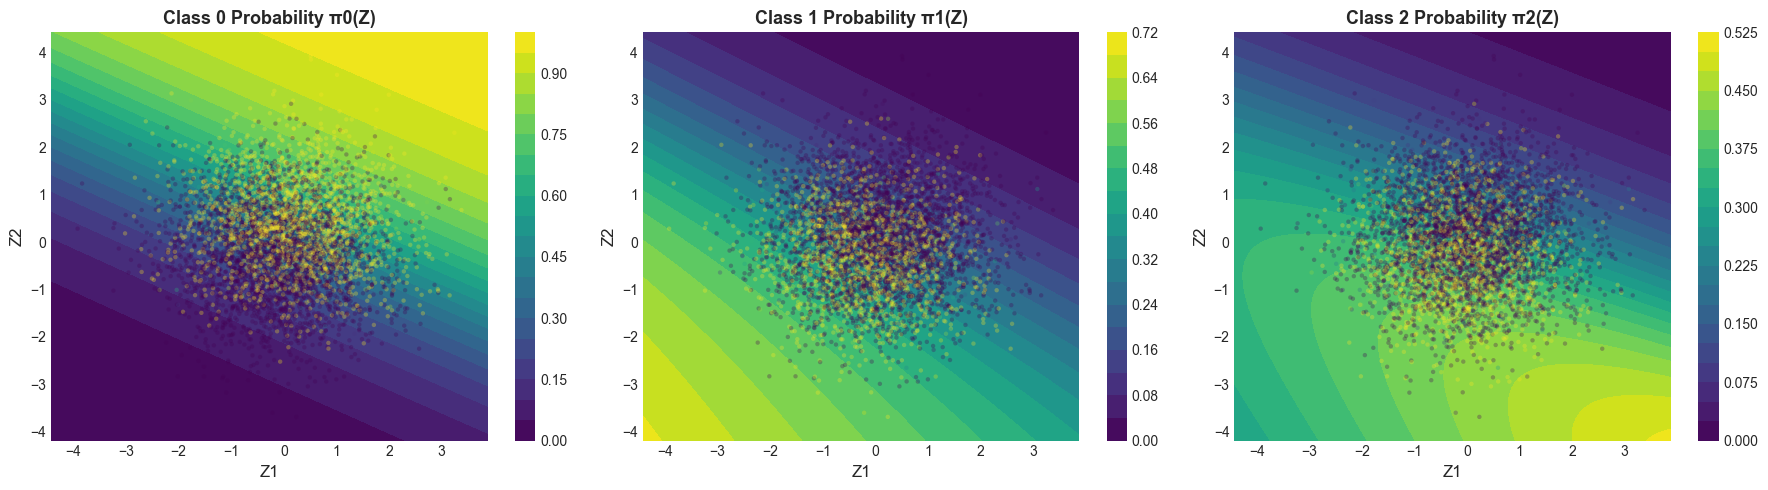

In [10]:
if covariate_dim == 2:
    # Create grid of covariate values
    z1_range = np.linspace(Z[:, 0].min() - 0.5, Z[:, 0].max() + 0.5, 100)
    z2_range = np.linspace(Z[:, 1].min() - 0.5, Z[:, 1].max() + 0.5, 100)
    Z1_grid, Z2_grid = np.meshgrid(z1_range, z2_range)
    Z_grid = np.column_stack([Z1_grid.ravel(), Z2_grid.ravel()])
    
    # Compute pi(Z) for grid points
    pi_grid = model._compute_pi(Z_grid)
    
    # Plot for each class
    fig, axes = plt.subplots(1, n_classes, figsize=(6 * n_classes, 5))
    
    if n_classes == 1:
        axes = [axes]
    
    for k in range(n_classes):
        pi_k_grid = pi_grid[:, k].reshape(Z1_grid.shape)
        
        im = axes[k].contourf(Z1_grid, Z2_grid, pi_k_grid, levels=20, cmap='viridis')
        axes[k].scatter(Z[:, 0], Z[:, 1], c=gamma[:, k], cmap='viridis', 
                       s=10, alpha=0.3, edgecolors='none')
        axes[k].set_xlabel('Z1', fontsize=12)
        axes[k].set_ylabel('Z2', fontsize=12)
        axes[k].set_title(f'Class {k} Probability π{k}(Z)', fontsize=13, fontweight='bold')
        plt.colorbar(im, ax=axes[k])
    
    plt.tight_layout()
    plt.show()

elif covariate_dim == 1:
    # For 1D covariates, plot pi_k(z) as line plots
    z_range = np.linspace(Z.min() - 0.5, Z.max() + 0.5, 200).reshape(-1, 1)
    pi_z = model._compute_pi(z_range)
    
    plt.figure(figsize=(10, 6))
    for k in range(n_classes):
        plt.plot(z_range, pi_z[:, k], linewidth=2, label=f'Class {k}')
    
    plt.xlabel('Z', fontsize=12)
    plt.ylabel('Class Probability', fontsize=12)
    plt.title('Class Probabilities π_k(Z) vs Covariate Z', fontsize=14, fontweight='bold')
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

else:
    print(f"Covariate dimension is {covariate_dim} (> 2), skipping visualization of pi_k(Z)")

### 5.6 Confusion Matrix: True vs Predicted Classes

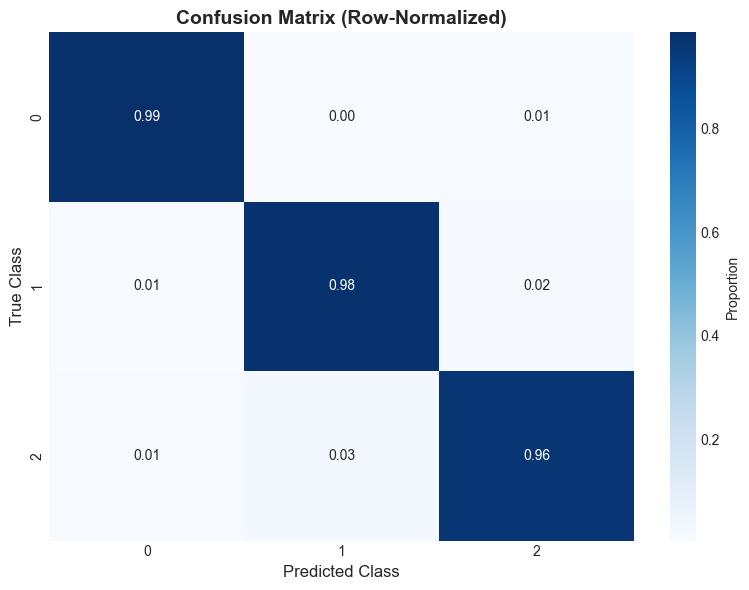


Classification Accuracy: 0.9756


In [11]:
# Get hard class assignments
predicted_classes = gamma.argmax(axis=1)
true_classes = true_params_sorted['H']  # Use sorted true classes for fair comparison

# Compute confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_classes, predicted_classes)

# Normalize by row (true class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=range(n_classes), yticklabels=range(n_classes),
            cbar_kws={'label': 'Proportion'})
plt.xlabel('Predicted Class', fontsize=12)
plt.ylabel('True Class', fontsize=12)
plt.title('Confusion Matrix (Row-Normalized)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Compute accuracy
accuracy = np.sum(predicted_classes == true_classes) / len(true_classes)
print(f"\nClassification Accuracy: {accuracy:.4f}")

## 6. Model Evaluation Metrics

In [12]:
# Compute various metrics
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# Adjusted Rand Index
ari = adjusted_rand_score(true_classes, predicted_classes)
print(f"Adjusted Rand Index: {ari:.4f}")

# Normalized Mutual Information
nmi = normalized_mutual_info_score(true_classes, predicted_classes)
print(f"Normalized Mutual Information: {nmi:.4f}")

# Final log-likelihood
final_log_lik = model.log_likelihoods[-1]
print(f"\nFinal Log-likelihood: {final_log_lik:.4f}")

# BIC (Bayesian Information Criterion)
n_params = (n_classes - 1) * (1 + covariate_dim)  # alpha and beta
n_params += sum([(n_classes * (c - 1)) for c in categories_per_variable])  # theta
bic = -2 * final_log_lik + n_params * np.log(n_samples)
print(f"BIC: {bic:.4f}")
print(f"Number of parameters: {n_params}")

Adjusted Rand Index: 0.9314
Normalized Mutual Information: 0.8830

Final Log-likelihood: -53860.8088
BIC: 108283.7524
Number of parameters: 66


## 7. Parameter Comparison

In [13]:
# Compare learned vs true alpha and beta (using sorted true params)
print("\n" + "="*60)
print("PARAMETER COMPARISON (After entropy-based sorting)")
print("="*60)

print("\nAlpha (intercepts):")
print(f"  True:    {true_params_sorted['alpha']}")
print(f"  Learned: {model.alpha}")

print("\nBeta (coefficients):")
for k in range(n_classes - 1):
    print(f"  Class {k}:")
    print(f"    True:    {true_params_sorted['beta'][k]}")
    print(f"    Learned: {model.beta[k]}")

# Compute MSE for theta
theta_mse = 0.0
n_theta_params = 0
for k in range(n_classes):
    for r in range(n_variables):
        true_theta_kr = true_params_sorted['theta'][k, r, :categories_per_variable[r]]
        learned_theta_kr = model.theta[k, r, :categories_per_variable[r]]
        theta_mse += np.sum((true_theta_kr - learned_theta_kr) ** 2)
        n_theta_params += categories_per_variable[r]

theta_mse /= n_theta_params
print(f"\nTheta MSE: {theta_mse:.6f}")


PARAMETER COMPARISON (After entropy-based sorting)

Alpha (intercepts):
  True:    [ 0.24835708 -0.06913215]
  Learned: [ 0.2017454 -0.057057 ]

Beta (coefficients):
  Class 0:
    True:    [0.32384427 0.76151493]
    Learned: [0.33992162 0.77702554]
  Class 1:
    True:    [-0.11707669 -0.11706848]
    Learned: [-0.12410861 -0.0757456 ]

Theta MSE: 0.000102
